<a href="https://colab.research.google.com/github/nicikess/hsg-ml-course/blob/main/notebooks/ml_challenge_ResNet_50_with_3_channels_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import pandas as pd
import numpy as np
from PIL import Image

!pip install rasterio
!pip install tqdm
import rasterio
from rasterio.plot import reshape_as_image
from tqdm import tqdm

!pip install torchgeo
import torchgeo.models

from datetime import datetime

from tifffile import imread

from sklearn.metrics import confusion_matrix
from sklearn import model_selection

import torch, torchvision
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor

     |████████████████████████████████| 19.3 MB 13.9 MB/s 
     |████████████████████████████████| 204 kB 15.1 MB/s 
     |████████████████████████████████| 1.0 MB 86.9 MB/s 
     |████████████████████████████████| 88 kB 8.5 MB/s 
     |████████████████████████████████| 493 kB 66.0 MB/s 
     |████████████████████████████████| 6.3 MB 88.1 MB/s 
     |████████████████████████████████| 431 kB 91.6 MB/s 
     |████████████████████████████████| 16.7 MB 88.4 MB/s 
     |████████████████████████████████| 74 kB 4.0 MB/s 
     |████████████████████████████████| 409 kB 82.1 MB/s 
     |████████████████████████████████| 584 kB 90.0 MB/s 
     |████████████████████████████████| 596 kB 62.1 MB/s 
     |████████████████████████████████| 112 kB 91.0 MB/s 
     |████████████████████████████████| 136 kB 88.3 MB/s 
     |████████████████████████████████| 1.1 MB 57.9 MB/s 
     |████████████████████████████████| 58 kB 7.8 MB/s 
     |████████████████████████████████| 376 kB 86.1 MB/s 
     |████████████

In [3]:
#Loads tiff folders

import os
folder = '/content/drive/MyDrive/ML/data/dataset/trainset/'
subfolders = []
for dirs in os.walk(folder):
  subfolders.append(dirs[0])

#remove directory
subfolders.pop(0)
for i in range(0, len(subfolders)):
     print(subfolders[i])

/content/drive/MyDrive/ML/data/dataset/trainset/AnnualCrop
/content/drive/MyDrive/ML/data/dataset/trainset/Forest
/content/drive/MyDrive/ML/data/dataset/trainset/HerbaceousVegetation
/content/drive/MyDrive/ML/data/dataset/trainset/Highway
/content/drive/MyDrive/ML/data/dataset/trainset/Industrial
/content/drive/MyDrive/ML/data/dataset/trainset/Pasture
/content/drive/MyDrive/ML/data/dataset/trainset/PermanentCrop
/content/drive/MyDrive/ML/data/dataset/trainset/Residential
/content/drive/MyDrive/ML/data/dataset/trainset/River
/content/drive/MyDrive/ML/data/dataset/trainset/SeaLake


In [4]:
#Define paths

ROOT_PATH = '/content/drive/MyDrive/ML/'
BASE_PATH = os.path.join(ROOT_PATH, 'data')
MODEL_PATH = os.path.join(ROOT_PATH, 'model')

file_path_train = '/content/drive/MyDrive/ML/data/dataset/train.csv'
file_path_test = '/content/drive/MyDrive/ML/data/dataset/test.csv'
data_df_train = pd.read_csv(file_path_train)
data_df_test = pd.read_csv(file_path_test)

data_df_train.columns = data_df_train.columns.str.replace('path', 'image_id')
data_df_train.columns = data_df_train.columns.str.replace('Label', 'label')

In [5]:
data_df_train.head()

,image_id,label
0,AnnualCrop/AnnualCrop_135.tif,AnnualCrop
1,AnnualCrop/AnnualCrop_692.tif,AnnualCrop
2,AnnualCrop/AnnualCrop_2218.tif,AnnualCrop
3,AnnualCrop/AnnualCrop_2679.tif,AnnualCrop
4,AnnualCrop/AnnualCrop_926.tif,AnnualCrop


In [6]:
type(data_df_train)

pandas.core.frame.DataFrame

In [7]:
#Init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

In [8]:
#Classes and labels

IDX_CLASS_LABELS = {
    0: 'AnnualCrop',
    1: 'Forest', 
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

CLASSES = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture','PermanentCrop','Residential','River', 'SeaLake']
CLASS_IDX_LABELS = dict()
for key, val in IDX_CLASS_LABELS.items():
  CLASS_IDX_LABELS[val] = key

NUM_CLASSES = len(IDX_CLASS_LABELS.items())
torch.manual_seed(10)
VALID_SIZE = 0.1

In [9]:
#Encoder and decoder

## Give idx of each class name
def encode_label(label):
    idx = CLASS_IDX_LABELS[label] 
    return idx

## Take in idx and return the class name
def decode_target(target, text_labels=True):
    result = []
    if text_labels:
        return IDX_CLASS_LABELS[target]
    else:
        return target

In [10]:
#Open tiff files with rasterio and safe to dictionary

'''import os

data = {}

for i in range(len(subfolders)):

  txtfiles = []

  # traverse whole directory
  for root, dirs, files in os.walk(subfolders[i]):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('.tif'):
            txtfiles.append(os.path.join(root, file))

  code = subfolders[i].split('/')[8]
  index = encode_label(code)
  arr = np.zeros([len(txtfiles), 64, 64, 13], dtype="float32")

  print(code)
  print(index)

  i = 0
  for pic in txtfiles:
    with rasterio.open(pic, "r") as img:
      arr[i] = np.moveaxis(img.read(), 0, 2)
      i += 1
      
  data[index] = arr'''

'import os\n\ndata = {}\n\nfor i in range(len(subfolders)):\n\n  txtfiles = []\n\n  # traverse whole directory\n  for root, dirs, files in os.walk(subfolders[i]):\n    # select file name\n    for file in files:\n        # check the extension of files\n        if file.endswith(\'.tif\'):\n            txtfiles.append(os.path.join(root, file))\n\n  code = subfolders[i].split(\'/\')[8]\n  index = encode_label(code)\n  arr = np.zeros([len(txtfiles), 64, 64, 13], dtype="float32")\n\n  print(code)\n  print(index)\n\n  i = 0\n  for pic in txtfiles:\n    with rasterio.open(pic, "r") as img:\n      arr[i] = np.moveaxis(img.read(), 0, 2)\n      i += 1\n      \n  data[index] = arr'

In [11]:
#Save the files as .npy

'''for i in range(len(data)):
  keys_list = list(data)
  key = keys_list[i]
  np.save('/content/drive/MyDrive/ML/data/dataset/trainset/'+f'data_class{key}.npy', data[i], allow_pickle=True, fix_imports=True)'''

"for i in range(len(data)):\n  keys_list = list(data)\n  key = keys_list[i]\n  np.save('/content/drive/MyDrive/ML/data/dataset/trainset/'+f'data_class{key}.npy', data[i], allow_pickle=True, fix_imports=True)"

In [12]:
#Reload the .npy files

import os
path = '/content/drive/MyDrive/ML/data/dataset/trainset/'
npyfiles = []
data = {}

for root, dirs, files in os.walk(path):
    # check the extension of files
    for file in files:
        # check the extension of files
        if file.endswith('.npy'):
            npyfiles.append(os.path.join(root, file))

for i in range(len(npyfiles)):
  path = npyfiles[i]
  arr = np.load(path)
  index = path.split('/')[8].split('_')[1][5]
  index = int(index)
  data[index] = arr

In [13]:
from pathlib import Path
class EuroSAT(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform

    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        row = self.train_df.loc[idx]
        img_id, label = row['image_id'], row['label']
        img_id = int(img_id.split('.')[0].split('_')[1])
        label_encode = int(encode_label(label))
        id = img_id - 1
        img = data[label_encode][id]
        img_rgb = img[:, :, [4,3,2]]
        if self.transform:
            img_rgb = self.transform(img_rgb)
        return img_rgb, encode_label(label)

In [14]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.ConvertImageDtype(torch.float),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    #transforms.RandomRotation(degrees=(30, 70)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [15]:
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),transforms.ConvertImageDtype(torch.float),torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_ds = EuroSAT(data_df_train, BASE_PATH, transf)
print(len(train_ds))

27000


In [17]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))
    
    return (band_data - lower_perc) / (upper_perc - lower_perc)

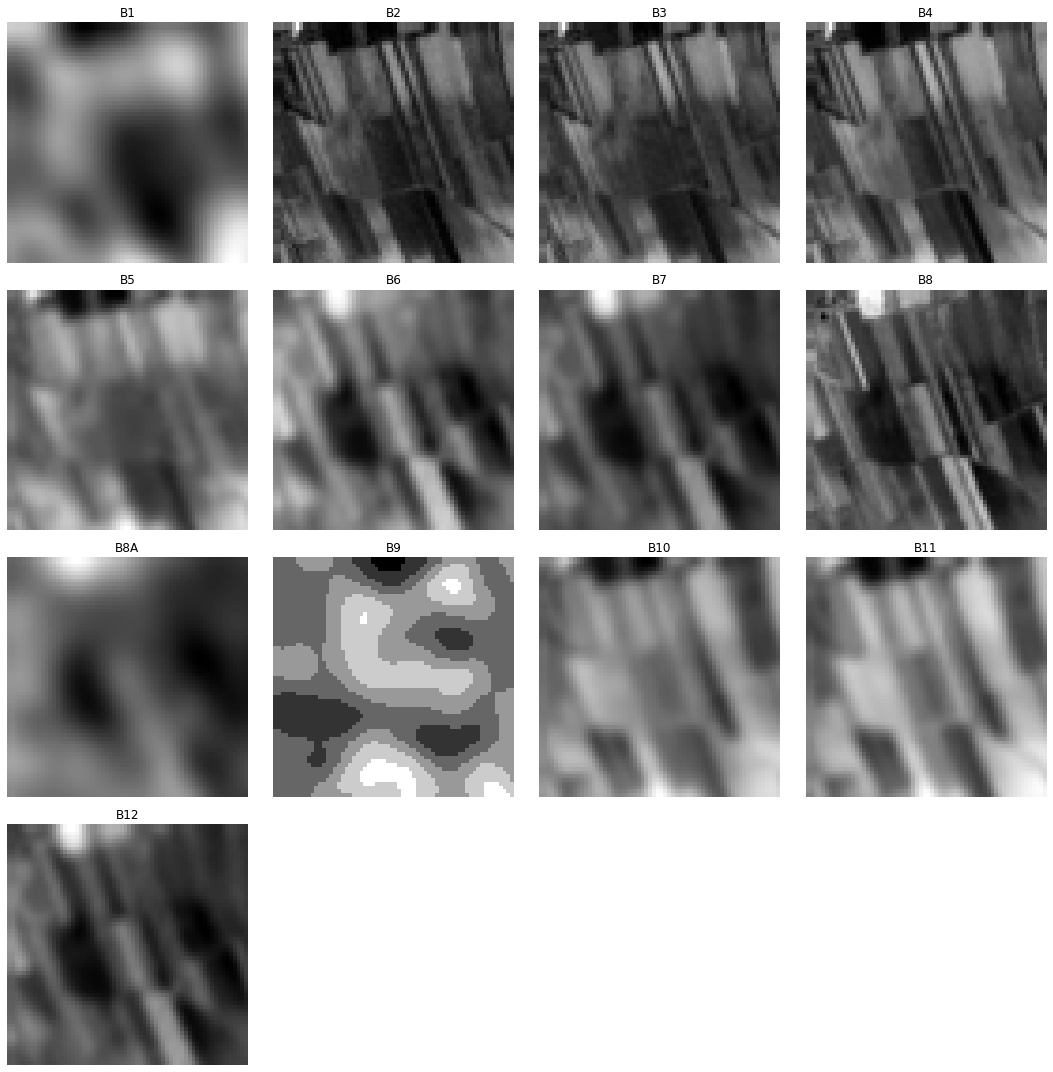

In [38]:
img = data[5][1]
normalized_img = normalize_for_display(img)
fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12", "B13"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")
        
        axs[i,j].axis(False)
        band_idx += 1
        
plt.tight_layout()
plt.show()

TypeError: ignored

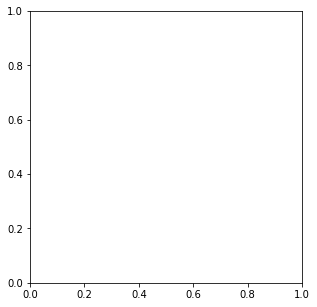

In [55]:
rgb_img = normalized_img[:, :, [2]]
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"{label}")
ax.axis(False)
plt.tight_layout()

plt.show()

In [21]:
train_size = int(0.8 * len(data_df_train))
test_size = len(data_df_train) - train_size
train_ds, validation_ds = torch.utils.data.random_split(train_ds, [train_size, test_size])

In [22]:
print(len(train_ds))
print(len(validation_ds))

21600
5400


Model

In [ ]:
pretrainedBool = True
model = models.wide_resnet50_2(pretrained=True)
if pretrainedBool:
    for param in model.parameters():
        param.requires_grad = False
n_inputs = model.fc.in_features
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(256, NUM_CLASSES),
                      nn.LogSoftmax(dim=1)
                        )

In [ ]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cuda computation enabled


In [ ]:
model = model.to(device)

In [ ]:
# define the optimization criterion / loss function
ce_loss = nn.CrossEntropyLoss()

In [ ]:
ce_loss = ce_loss.to(device)

In [ ]:
# define learning rate and optimization strategy
learning_rate: 0.001
params = model.fc.parameters() if pretrainedBool else model.parameters()
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=1e-3)

In [ ]:
# specify the training parameters
num_epochs = 50 # number of training epochs
mini_batch_size = 1300 # size of the mini-batches

In [ ]:
train_dl = DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
grad_clip = 0.1
epochs = 50

In [ ]:
train(epochs, model, train_dl, grad_clip)

In [ ]:
def train(epochs, model, train_loader, grad_clip=None):
  
  # init collection of training epoch losses
  train_epoch_losses = []

  # set the model in training mode
  model.train()

  # train the CIFAR10 model
  for epoch in range(num_epochs):
      
      # init collection of mini-batch losses
      train_mini_batch_losses = []

      # iterate over all-mini batches
      for i, (images, labels) in enumerate(train_dl):

          #print(images)

          # push mini-batch data to computation device
          images = images.to(device)
          labels = labels.to(device)

          # run forward pass through the network
          output = model(images)
          
          # reset graph gradients
          model.zero_grad()
          
          # determine classification loss
          loss = ce_loss(output, labels)
          
          # run backward pass
          loss.backward()

          if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
          
          # update network paramaters
          optimizer.step()
          
          # collect mini-batch reconstruction loss
          train_mini_batch_losses.append(loss.data.item())

      # determine mean min-batch loss of epoch
      train_epoch_loss = np.mean(train_mini_batch_losses)
      
      # print epoch loss
      now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
      print('[LOG {}] epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
      
      # set filename of actual model
      model_name = 'challenge_model_epoch_{}.pth'.format(str(epoch))

      # save current model to GDrive models directory
      torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name))
      
      # determine mean min-batch loss of epoch
      train_epoch_losses.append(train_epoch_loss)

In [23]:
import os
path = '/content/drive/MyDrive/ML/data/dataset/testset/'
npyfiles = []
datatest = {}

for root, dirs, files in os.walk(path):
    # check the extension of files
    for file in files:
        # check the extension of files
        if file.endswith('.npy'):
            npyfiles.append(os.path.join(root, file))

for i in range(len(npyfiles)):
  path = npyfiles[i]
  arr = np.load(path)
  index = int(path.split('_')[1].split('.')[0])
  datatest[index] = arr

In [24]:
from pathlib import Path
class EuroSATTest(Dataset):
    def __init__(self, train_df, train_dir, transform=None):
        self.train_dir = train_dir
        self.train_df = train_df
        self.transform = transform

    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self, idx):
        img = datatest[idx]
        img = img[:, :, [4,3,2]]
        img = np.float32(img)
        if self.transform:
            img = self.transform(img)
        return img

In [25]:
#Test data
transf = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_ds = EuroSATTest(data_df_test, BASE_PATH, transf)
print(len(test_ds))

4232


IndexError: ignored

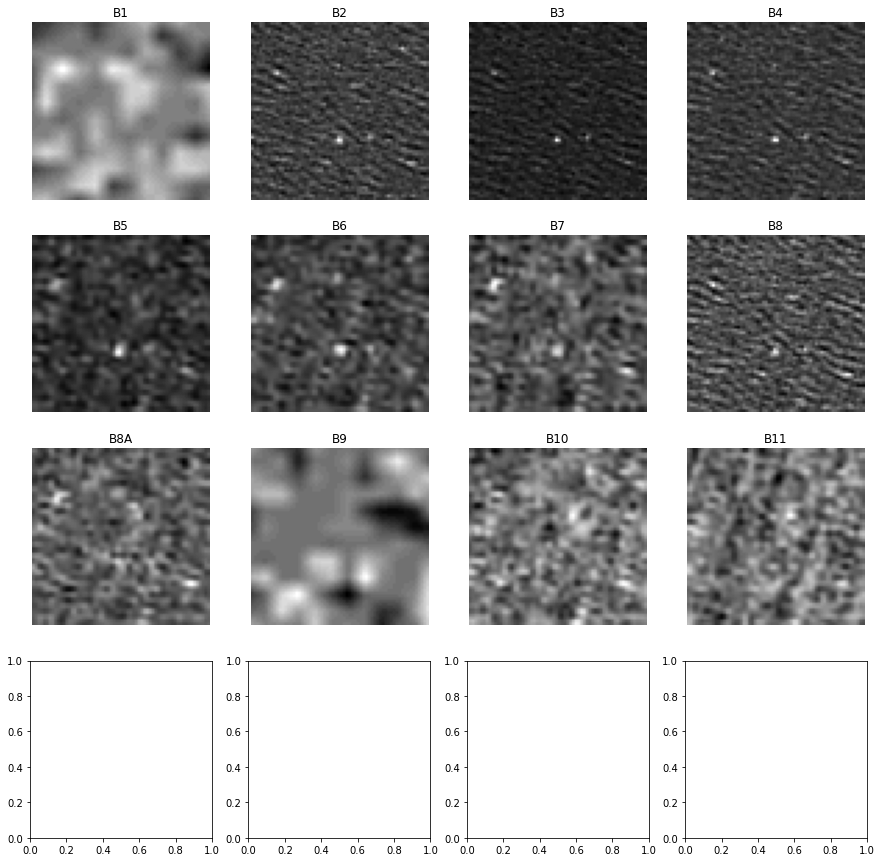

In [37]:
img = datatest[3]
normalized_img = normalize_for_display(img)
fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12", "B13"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")
        
        axs[i,j].axis(False)
        band_idx += 1
        
plt.tight_layout()
plt.show()

In [ ]:
resnet50_vali_dataloader = DataLoader(validation_ds, batch_size=5400, num_workers=2, pin_memory=True)

In [ ]:
resnet50_test_dataloader = DataLoader(test_ds, batch_size=10_000, num_workers=2, pin_memory=True)

In [ ]:
# Display image and label.
validation_features, validation_labels = next(iter(resnet50_vali_dataloader))
print(f"Labels batch shape: {validation_labels.size()}")

Labels batch shape: torch.Size([5400])


In [ ]:
# restore pre-trained model snapshot
best_model_name = os.path.join(MODEL_PATH, 'challenge_model_epoch_44.pth')

# load state_dict from path
state_dict_best = torch.load(best_model_name, map_location=torch.device('cpu'))

# init pre-trained model class
best_model = model

# load pre-trained models
best_model.load_state_dict(state_dict_best)

<All keys matched successfully>

In [ ]:
# set model in evaluation mode
best_model.eval()

In [ ]:
#Validation
#next() returns a tupel: tensor,label
predictions = torch.argmax(best_model(iter(resnet50_vali_dataloader).next()[0].to(device)), dim=1)

In [ ]:
#Test
predictions = torch.argmax(best_model(iter(resnet50_test_dataloader).next().to(device)), dim=1)

In [ ]:
type(predictions)

torch.Tensor

In [ ]:
list_tens = predictions.tolist()

for i in range(len(list_tens)):
  list_tens[i] = decode_target(list_tens[i])

In [ ]:
from collections import Counter
print(Counter(list_tens).keys()) # equals to list(set(words))
print(Counter(list_tens).values()) # counts the elements' frequency

dict_keys(['HerbaceousVegetation', 'Industrial', 'Forest', 'SeaLake', 'Residential', 'Highway', 'PermanentCrop', 'River', 'Pasture', 'AnnualCrop'])
dict_values([632, 497, 627, 600, 580, 576, 412, 468, 392, 616])


In [ ]:
from sklearn import metrics
metrics.accuracy_score(validation_labels.detach().cpu(), predictions.detach().cpu())

0.8346296296296296

In [ ]:
test_indices_path = '/content/drive/MyDrive/ML/data/dataset/test.csv'

final_submission_file = pd.read_csv(test_indices_path)
prediction_list = []

# turning numeric predictions to strings (as in kaggle example submission)
for p in predictions:
  prediction_list.append(decode_target(p.item()))

final_submission_file["label"] = prediction_list
### source with alternatives methods for appending to csv should this fail: https://stackoverflow.com/questions/26666919/add-column-in-dataframe-from-list
final_submission_file.to_csv('/content/drive/MyDrive/ML/data/dataset/final_submission.csv', index=None)